In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [143]:
#Variables...

'''
('min0', 83)
('max0', 85)
('min1', 93)
('max1', 99)
('min2', 43)
('max2', 45)
'''

# Puck HSV Bounds (Green)
#pucklowerBound=np.array([182,100,50])
#puckupperBound=np.array([104,170,160])

# Puck HSV Bounds (pink)
#pucklowerBound=np.array([158,42,91])
#puckupperBound=np.array([175,92,242])
pucklowerBound=np.array([122,57,9])
puckupperBound=np.array([132,93,254])

# Bot HSV Bounds (White 3dPrint)
#botlowerBound=np.array([95,15,165])
#botupperBound=np.array([110,30,180])

# red thing on top of bot
#botlowerBound=np.array([100,140,110])
#botupperBound=np.array([120,185,150])

#Blue post-it
botlowerBound=np.array([9,83,9])
botupperBound=np.array([42,127,254])


'''
corner_lower=np.array([75,130,120])
corner_upper=np.array([90,210,190])
[79,106,155]
[84,144,212]


[30,32,18]
[38,61,26]


[110,160,133]
[118,194,157]

[12,157,88]
[18,202,130]

[119,138,70]
[129,255,178]

[121,170,90]
[127,255,172]

[122,199,130]
[126,223,160]

corner_lower=np.array([75,130,120])
corner_upper=np.array([90,210,190])
'''

corner_lower=np.array([122,199,130])
corner_upper=np.array([126,223,160])

side_lower = np.array([47,47,110])
side_upper = np.array([62,112,174])

goal_lower = np.array([17,114,87])
goal_upper = np.array([26,168,111])


#corner_lower=np.array([75,106,120])
#corner_upper=np.array([90,210,200])

In [144]:
def cleanMask(dirty_mask):
    points = []
    for i in range(dirty_mask.shape[0]):
        for j in range(dirty_mask.shape[1]):
            if dirty_mask[i, j] == 255:
                points.append((i,j))
    #Remove exterior dots
    padding = 2
    from collections import deque
    remaining_points = set(points)
    saved_locations = []
    while remaining_points:
        current_point = remaining_points.pop()
        y = current_point[0]
        x = current_point[1]
        saved_points = set()
        horizon = deque([(y-1,x-1),(y+1,x-1),(y-1,x+1),(y+1,x+1)])
        saved_points.add(current_point)
        while(len(horizon) > 0):
            to_check = horizon.pop()
            y = to_check[0]
            x = to_check[1]
            if to_check in remaining_points:
                remaining_points.discard(to_check)
                horizon.appendleft((y-1,x-1))
                horizon.appendleft((y+1,x-1))
                horizon.appendleft((y-1,x+1))
                horizon.appendleft((y+1,x+1))
                saved_points.add(to_check)
        saved_locations.append(saved_points)
    cleaned_mask = dirty_mask.copy()
    cleaned_mask[:,:] = 0
    max_location = set()
    for location in saved_locations:
        if location:
            if len(location) > len(max_location):
                max_location = location

    for y, x in max_location:
        cleaned_mask[y-padding:y+padding,x-padding:x+padding] = 255
        
    return cleaned_mask;

def getHSVMask(hsv_img, range_lower_bound, range_upper_bound):
    hsv_mask=cv2.inRange(hsv_img,range_lower_bound,range_upper_bound)
    return hsv_mask

def getOpenCloseMask(orig_mask):
    kernelOpen=np.ones((3,3))
    kernelClose=np.ones((10,10))
    
    mask_open=cv2.morphologyEx(orig_mask,cv2.MORPH_OPEN,kernelOpen);
    mask_close=cv2.morphologyEx(orig_mask,cv2.MORPH_CLOSE,kernelClose);
    
    return mask_open,mask_close;

def getMaskRectangle(clean_mask, offset=0):
    # Get contours
    _, contours, _=cv2.findContours(clean_mask.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    
    # Determine biggest contour and use that.
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    contour_sizes.sort(key= lambda x: x[0], reverse=True)
    #print(contour_sizes)
    biggest_contour = contour_sizes[offset][1]

    #print 'biggest_contour';
    #biggest_contour;
    
    # Generate rect from contour
    x,y,w,h = cv2.boundingRect(biggest_contour);
    
    return x,y,w,h;

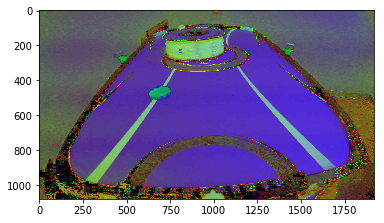

In [145]:
# Get Image
img=cv2.imread("red_test.jpg");

#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#convert image to HSV
#hsv_image=cv2.cvtColor(img[85:140,150:200,:], cv2.COLOR_BGR2HSV)
hsv_image=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#hsv_image=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(hsv_image)

#gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#gray = cv2.bilateralFilter(gray, 11, 17, 17)

#edged = cv2.Canny(gray, 30, 200)
#plt.imshow(edged)

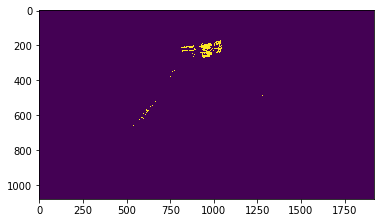

In [146]:
# Get HSV Mask for bot and puck from HSV image.
puck_mask=getHSVMask(hsv_image.copy(),pucklowerBound, puckupperBound);
bot_mask=getHSVMask(hsv_image.copy(),botlowerBound,botupperBound);
corner_mask=getHSVMask(hsv_image.copy(),corner_lower,corner_upper)
side_mask = getHSVMask(hsv_image.copy(),side_lower, side_upper)
goal_mask = getHSVMask(hsv_image.copy(),goal_lower, goal_upper)
#plt.imshow(puck_mask)
#plt.imshow(bot_mask)
plt.imshow(corner_mask)
#plt.imshow(side_mask)
#plt.imshow(goal_mask)

In [147]:
#Get open & Close mask
puck_mask_open,puck_mask_close=getOpenCloseMask(puck_mask);
bot_mask_open,bot_mask_close=getOpenCloseMask(bot_mask);
corner_mask_open,corner_mask_close=getOpenCloseMask(corner_mask)
side_mask_open, side_mask_close = getOpenCloseMask(side_mask)
goal_mask_open, goal_mask_close = getOpenCloseMask(goal_mask)

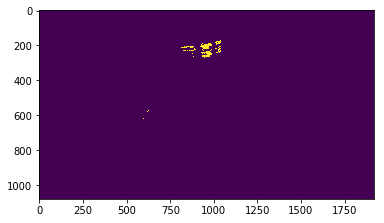

In [148]:
#plt.imshow(puck_mask_close)
#plt.imshow(puck_mask_open)
#plt.imshow(bot_mask_open)
plt.imshow(corner_mask_open)
#plt.imshow(goal_mask_open)

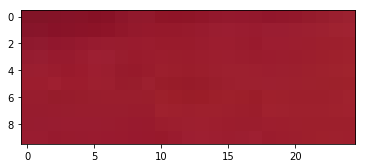

In [149]:
y_lo = 210
y_hi = 220
x_lo = 950
x_hi = 975
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image[y_lo:y_hi, x_lo:x_hi, :])

[122,199,130]
[126,223,160]


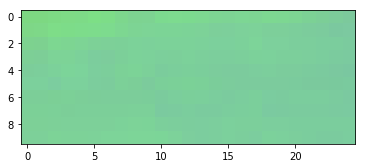

In [150]:
itemToFind=hsv_image.copy()[y_lo:y_hi, x_lo:x_hi, :]

plt.imshow(itemToFind)
#print(itemToFind)
print("[" + str(np.amin(itemToFind[:,:,0])) + "," +str(np.amin(itemToFind[:,:,1])) + "," +str(np.amin(itemToFind[:,:,2])) +"]")
print("[" + str(np.amax(itemToFind[:,:,0])) + "," +str(np.amax(itemToFind[:,:,1])) + "," +str(np.amax(itemToFind[:,:,2])) +"]")


In [151]:
#px,py,pw,ph = getMaskRectangle(puck_mask_open)
#bx,by,bw,bh = getMaskRectangle(bot_mask_open)

lcx,lcy,lcw,lch = getMaskRectangle(corner_mask_open)
#rcx,rcy,rcw,rch = getMaskRectangle(corner_mask_open, 1)
#fcx,fcy,fcw,fch = getMaskRectangle(corner_mask_open, 2)

#rcx=rcx+200
#fcy=fcy+100

#print(px,py,ph,pw)
#print(bx,by,bh)
#print(lcx,lcy,lcw,lch)
#print(rcx,rcy,rcw,rch)
#print(fcx,fcy,fcw,fch)

#lx, ly, lw, lh = getMaskRectangle(side_mask_open)
#rx, ry, rw, rh = getMaskRectangle(side_mask_open, 1)
#x, y, w, h = getMaskRectangle(goal_mask_open)
#plt.imshow(corner_back_left_mask_open)

In [152]:
def get_rect_mid(x, y, w, h):
    return x + w / 2, y + h / 2

def plot_mid(im, x, y, w, h, radius=3):
    x, y = get_rect_mid(x, y, w, h)
    im[y-radius:y+radius, x-radius:x+radius] = (0, 255, 255)

In [153]:
# Draw locations of puck and bot on image.
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#rect1=cv2.rectangle(image,(px,py),(px+pw,py+ph),(0,255,0),1)
#rect2=cv2.rectangle(image,(bx,by),(bx+bw,by+bh),(255,0,255),1)
rect3=cv2.rectangle(image,(lcx,lcy),(lcx+lcw,lcy+lch),(255,0,0),2)
#rect4=cv2.rectangle(image,(rcx,rcy),(rcx+rcw,rcy+rch),(255,0,0),2)
#rect5=cv2.rectangle(image,(fcx,fcy),(fcx+fcw,fcy+fch),(255,0,0),2)
#plot_mid(image, lcx, lcy, lcw, lch)
#plot_mid(image, rcx, rcy, rcw, rch)
#plot_mid(image, fcx, fcy, fcw, fch)
#rect6=cv2.rectangle(image,(lx,ly),(lx+lw,ly+lh),(255,0,0),2)
#plot_mid(image, lx, ly, lw, lh)
#rect7=cv2.rectangle(image,(rx,ry),(rx+rw,ry+rh),(255,0,0),2)
#plot_mid(image, rx, ry, rw, rh)
#rect8=cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
#plot_mid(image, x, y, w, h)

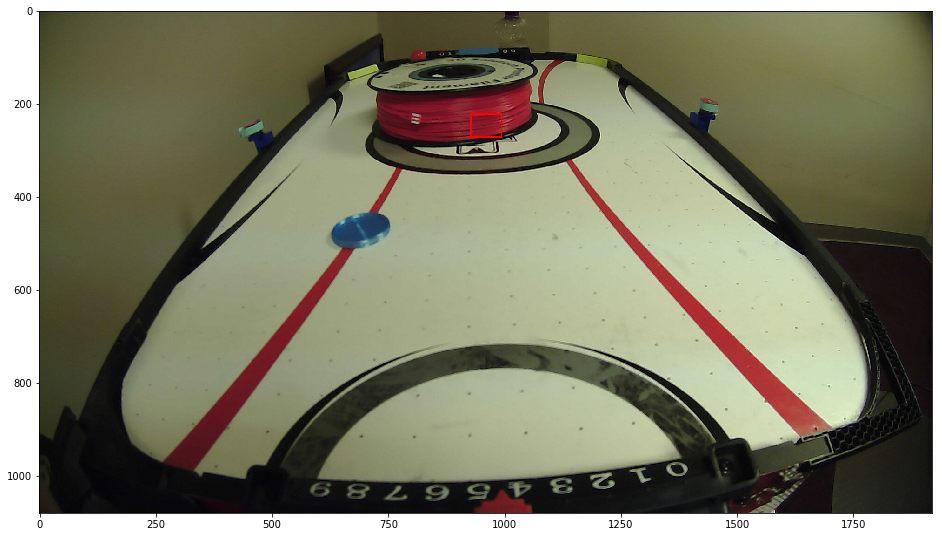

In [154]:
plt.figure(figsize=(16,16))
plt.imshow(image)

In [64]:
def get_coordinates(corner_mask, side_mask, goal_mask):
    rects = [getMaskRectangle(corner_mask), getMaskRectangle(corner_mask, 1), getMaskRectangle(corner_mask, 2), getMaskRectangle(corner_mask, 3)]
    rects.sort()
    #print(rects)
    coords = {}
    to_add = get_rect_mid(*rects[0])
    if to_add[0] < 960 and to_add[1] > 540:
        coords[(0,0)]     = to_add
    to_add = get_rect_mid(*rects[1])
    if to_add[0] < 960 and to_add[1] < 540:
        coords[(0,699)]   = to_add
    to_add = get_rect_mid(*rects[2])
    if to_add[0] > 960 and to_add[1] < 540:
        coords[(399,699)]   = to_add
    to_add = get_rect_mid(*rects[3])
    if to_add[0] > 960 and to_add[1] > 540:
        coords[(399,0)]   = to_add
    side_rects = [getMaskRectangle(side_mask), getMaskRectangle(side_mask, 1)]
    side_rects.sort()
    coords[(0, 350)]  = get_rect_mid(*side_rects[0])
    coords[(399, 350)]  = get_rect_mid(*side_rects[1])
    coords[(200, 699)] = get_rect_mid(*getMaskRectangle(goal_mask))
    #print(coords)
    return coords
    

In [65]:
def get_homographic_image(img_src, c_mask, s_mask, g_mask):
    coords = get_coordinates(c_mask, s_mask, g_mask)
    keys, values = zip(*coords.items())
    pts_dst = np.array(keys)
    pts_src = np.array(values)
    h, status = cv2.findHomography(pts_src, pts_dst)
    warped = cv2.warpPerspective(img_src, h, (400, 700))
    return warped
warped = get_homographic_image(img, corner_mask_open, side_mask_open, goal_mask_open)
plt.figure(figsize=(16, 16))
plt.imshow(warped)

IndexError: list index out of range